# import modules etc

In [1]:
import multiprocessing
import pandas as pd
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn import tree
import graphviz

---
# functions

In [2]:
def select_model_hyperparams(X, y):
    n_cpus = int(round(multiprocessing.cpu_count() * 0.875))
    
    print("using {} CPUs".format(n_cpus))
    
    tree_params = {"max_depth": [6],
                   "max_leaf_nodes": [13, 14, 15, 16, 17, 18, 19],
                   "min_samples_leaf": [1, 2, 4, 8]
                  }

    clf = GridSearchCV(tree.DecisionTreeClassifier(random_state=1),
                      param_grid=tree_params,
                      scoring="accuracy",
                      cv = RepeatedKFold(n_splits=5, n_repeats=20, random_state=2),
                      n_jobs=n_cpus,
                      verbose=1)

    return clf.fit(X, y)

### prepare input (X) data for train & test

In [3]:
def prepare_Xdata(data):
    feature_names = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
    X = data[feature_names]
    
    X = pd.get_dummies(X)
    new_feature_names = X.columns
    
    X.fillna(value=X.Age.median(), axis=1, inplace=True)
    
    return (X, new_feature_names)    

---
# main

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
print(train_data.shape)
print(test_data.shape)

(891, 12)
(418, 11)


In [5]:
X_train, feature_names = prepare_Xdata(train_data)
X_test, _ = prepare_Xdata(test_data)

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


In [7]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         418 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        418 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 18.5 KB


In [8]:
clf = select_model_hyperparams(X_train, train_data.Survived);

using 4 CPUs
Fitting 100 folds for each of 28 candidates, totalling 2800 fits


In [9]:
print("Best average validation score: {}".format(clf.best_score_.round(3)))
for pname, pvalue in clf.best_params_.items():
    print("  Param: {} = {}".format(pname, pvalue))

Best average validation score: 0.818
  Param: max_depth = 6
  Param: max_leaf_nodes = 16
  Param: min_samples_leaf = 2


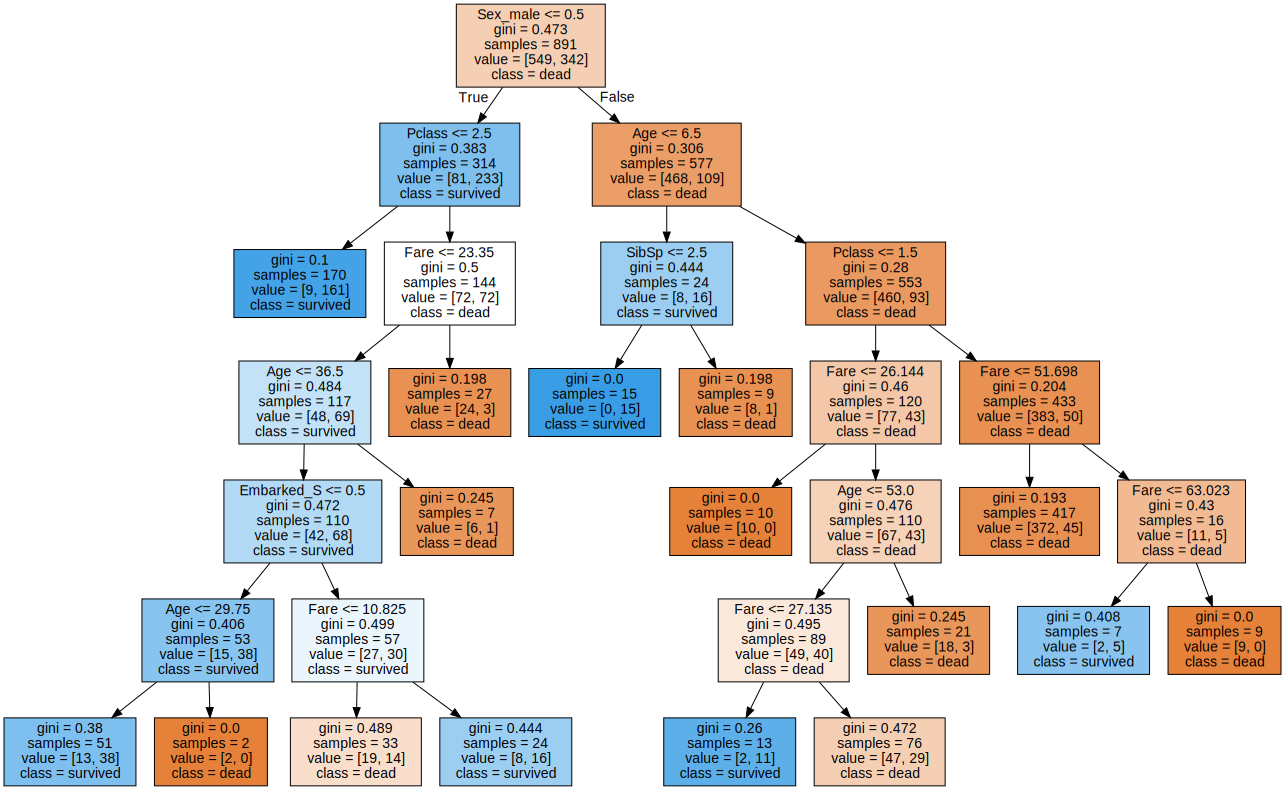

In [10]:
dot_data = tree.export_graphviz(clf.best_estimator_, out_file=None, 
                                feature_names=feature_names,  
                                class_names=["dead", "survived"],
                                filled=True)
    
tree_plot = graphviz.Source(dot_data, format="svg")
tree_plot

In [11]:
predictions = clf.predict(X_test)

In [12]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [13]:
output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [14]:
output.to_csv('submission_01_sc_dt.csv', index=False)